In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import special
import matplotlib.pyplot as plt
from skimage.morphology import flood_fill
import torch
from torch.autograd import gradcheck

## Let's start with some random 'Atoms' on a 2D plane

### Original Discrete Representation:

In [2]:
coords = np.random.random((10,2))

In [3]:
print("The discrete represntation shape is:", coords.shape)

The discrete represntation shape is: (10, 2)


In [4]:
coords

array([[0.09351149, 0.69863685],
       [0.84489965, 0.71691018],
       [0.93395185, 0.74593246],
       [0.60348014, 0.59408402],
       [0.91124729, 0.33968423],
       [0.38776003, 0.78788008],
       [0.75590713, 0.43913485],
       [0.63246571, 0.21669877],
       [0.2612007 , 0.47352585],
       [0.23823558, 0.96702594]])

(0, 1)

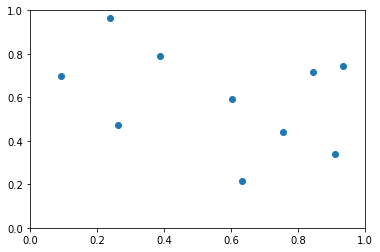

In [5]:
plt.scatter(coords[:,0],coords[:,1])
plt.ylim(0,1)
plt.xlim(0,1)

## Continuous Representation:

#### Let's do the 'forward' step of representing the coordinates as a 2D grid i.e. image

In [6]:
def coord_to_grid(coords, variance=0.04, grid_size=32):
    x_coords = np.linspace(0., 1, grid_size+1)
    y_coords = np.linspace(0., 1, grid_size+1)

    x_a, y_a = np.meshgrid(x_coords[:-1], y_coords[:-1])
    x_b, y_b = np.meshgrid(x_coords[1:], y_coords[1:])

    grid_a = np.vstack((x_a.flatten(), y_a.flatten())).T
    grid_b = np.vstack((x_b.flatten(), y_b.flatten())).T

    x_a = distance.cdist(grid_a[:,0].reshape(-1,1), coords[:,0].reshape(-1,1),lambda u,v: v-u)
    y_a = distance.cdist(grid_a[:,1].reshape(-1,1), coords[:,1].reshape(-1,1),lambda u,v: v-u)
    
    x_b = distance.cdist(grid_b[:,0].reshape(-1,1), coords[:,0].reshape(-1,1),lambda u,v: v-u)
    y_b = distance.cdist(grid_b[:,1].reshape(-1,1), coords[:,1].reshape(-1,1),lambda u,v: v-u)

    u_sub = np.sqrt(2) / (2 * variance)

    err_x = (special.erf(u_sub * x_a) - special.erf(u_sub * x_b))
    err_y = (special.erf(u_sub * y_a) - special.erf(u_sub * y_b))

    out = np.multiply(err_x, err_y).sum(-1) / 4
    out = out.reshape((grid_size,grid_size))
    return out

In [7]:
out = coord_to_grid(coords, variance=0.03)

In [8]:
print("The resolution of the image",out.shape)

The resolution of the image (32, 32)


### Let's take a look at what the origina image looks like

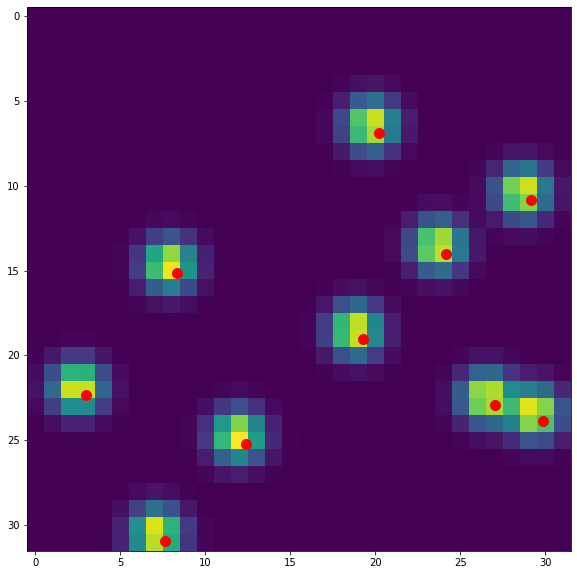

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.scatter(coords[:,0]*32, coords[:,1]*32, c='r', s=100)
# plt.ylim(0,32)

## Backward Step: 

#### We want to be able to retrieve the original discrete representation of the atoms

#### We will try to go from a (128,128) image to a (5,2) list

We start of with a simple thresholding

In [10]:
print("Quickly check the number of atoms: ", np.ceil(out.sum()))

Quickly check the number of atoms:  10.0


### Select the THRESHOLD starting points


In [11]:
THRESHOLD = out.max() - 2*out.std()
print("Intial number of non zero values: ", np.count_nonzero(out))
out[out < THRESHOLD] = 0
out[out > THRESHOLD] = 1
print("Binarized Thresholded number of non zero values: ", np.count_nonzero(out))

Intial number of non zero values:  934
Binarized Thresholded number of non zero values:  35


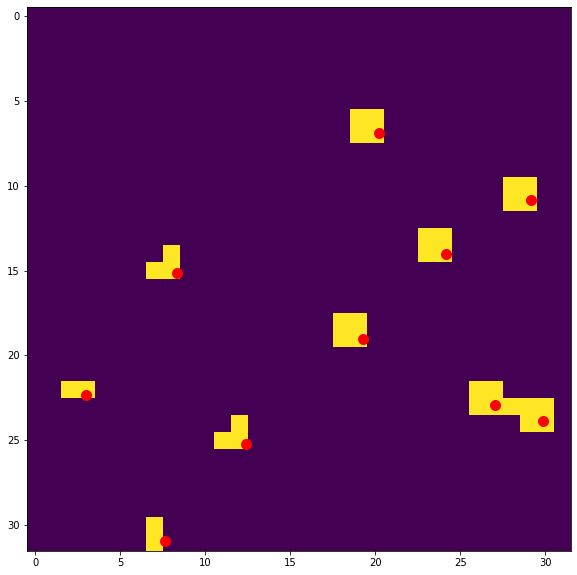

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.scatter(coords[:,0]*32, coords[:,1]*32, c='r', s=100)

In [13]:
possible_atom = np.unravel_index(out.argmax(), (32,32))
possible_atom

(6, 19)

In [15]:
atom_pos = []
possible_atom = np.unravel_index(out.argmax(), (32,32))
count = -1
while out[possible_atom] > 0:
    
    atom_pos.append(possible_atom)
    flood_fill(out, possible_atom, count , inplace=True)
    possible_atom = np.unravel_index(out.argmax(), (32,32))

    count -= 1

In [16]:
atom_pos = np.array(atom_pos)
print(atom_pos[:,[1,0]]/32)

[[0.59375 0.1875 ]
 [0.875   0.3125 ]
 [0.71875 0.40625]
 [0.25    0.4375 ]
 [0.5625  0.5625 ]
 [0.0625  0.6875 ]
 [0.8125  0.6875 ]
 [0.375   0.75   ]
 [0.21875 0.9375 ]]


### First approximation of possible atom positions

#### We can see that we are missing a few atoms still

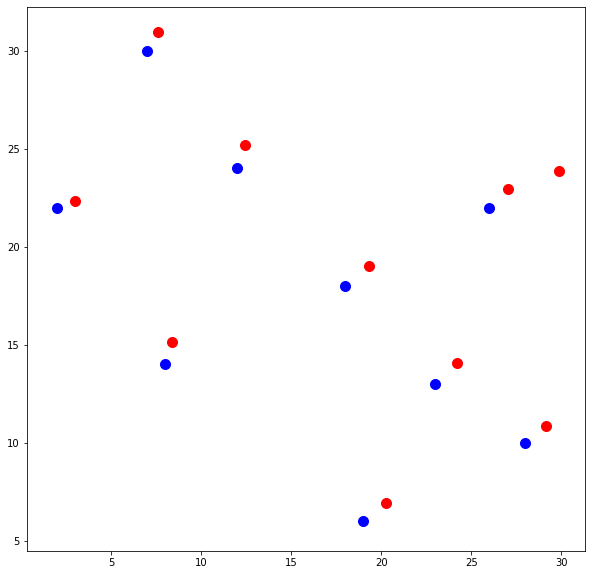

In [17]:
plt.figure(figsize=(10,10))
# plt.ylim(0,32)
# plt.imshow(out)
plt.scatter(coords[:,0]*32, coords[:,1]*32, c='r', s=100)
plt.scatter(atom_pos[:,1], atom_pos[:,0], c='b', s=100)

## What does the grid look like from approximate coordinates?

In [18]:
print(len(atom_pos))

9


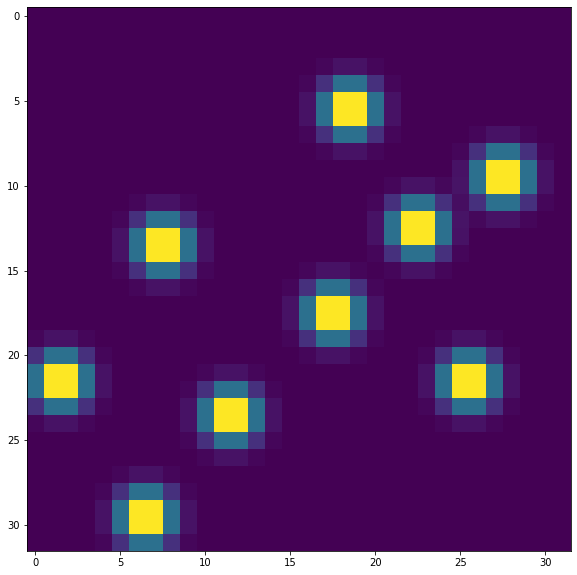

In [19]:
partial_coords = atom_pos[:,[1,0]]/32
partial_grid = coord_to_grid(partial_coords, variance=0.03)
plt.figure(figsize=(10,10))
# flood_fill(out, possible_atom, -1 , in_place=True)
plt.imshow(partial_grid)

### We can get the atoms missed in first pass

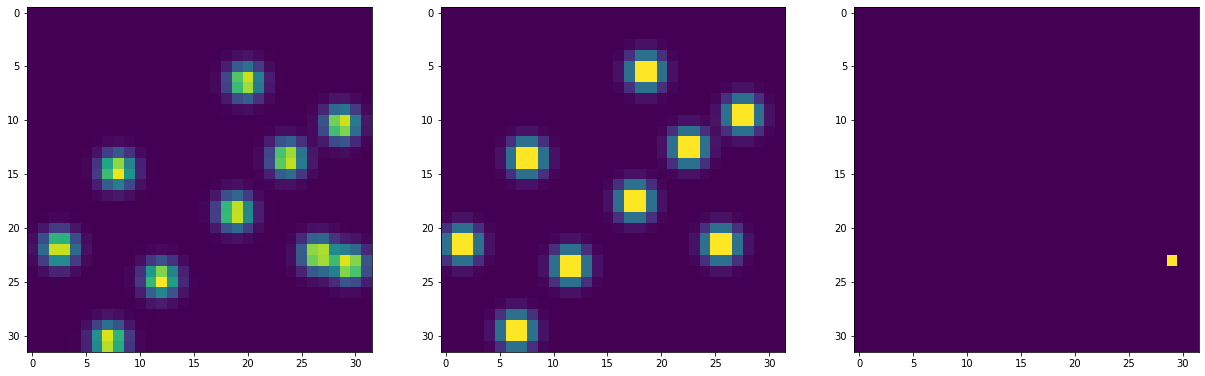

In [23]:
out = coord_to_grid(coords, variance=0.03)
new_grid = out - partial_grid
THRESHOLD = new_grid.max() - .5*new_grid.std()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,7))
# plt.ylim(0,32)
ax1.imshow(out)
ax2.imshow(partial_grid)


# flood_fill(out, possible_atom, -1 , in_place=True)
new_grid[new_grid < THRESHOLD] = 0
new_grid[new_grid > THRESHOLD] = 1

ax3.imshow(new_grid)

In [486]:
new_grid.argmax()

493

In [25]:
partial_pos = []
possible_atom = np.unravel_index(new_grid.argmax(), (32,32))
count = -1
print(new_grid.argmax())
while out[possible_atom] > 1e-6:
    partial_pos.append(possible_atom)
    print(out[possible_atom])
    flood_fill(new_grid, possible_atom, count , inplace=True)
    possible_atom = np.unravel_index(new_grid.argmax(), (32,32))
partial_pos = np.array(partial_pos)
print(partial_pos[:,[1,0]])

765
0.1437514498353251
[[29 23]]


# Our starting approximation of the atom positions

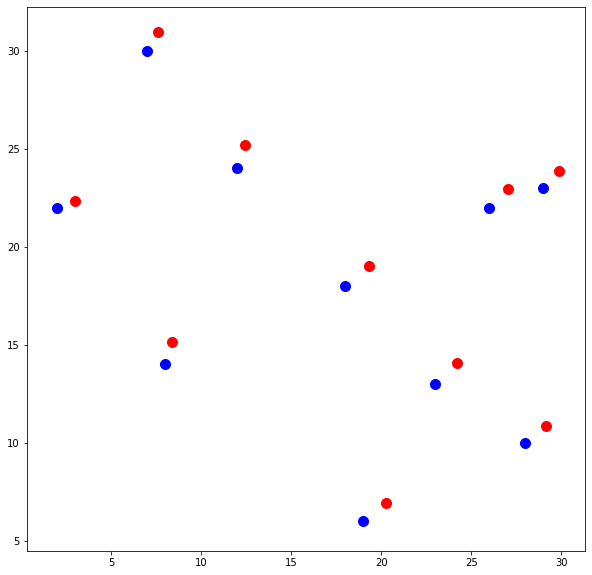

In [26]:
rem_coords = partial_pos[:,[1,0]] / 32

total_coords = np.concatenate([rem_coords, partial_coords], axis=0)

plt.figure(figsize=(10,10))
# plt.ylim(0,32)
# plt.imshow(out)
plt.scatter(coords[:,0]*32, coords[:,1]*32, c='r', s=100)
plt.scatter(total_coords[:,0]*32, total_coords[:,1]*32, c='b', s=100)

## Can we optimize the approximate positions? 

### The projected positions are very close but not an exact match. We can treat finding the exact positions of the atoms as an optimization problem! 
### By differentiably generating grids from the approximate coordinates, we can then compare with the original grid. Minimizing the positions of the found coordinates such that the grids difference is minimized provides us with the best possible approximation of the points

In [27]:
def torch_err_approx(val):
    """Differentiable error function to use with Torch
    """
    mask = val < 0
    
    with torch.no_grad():
        _val = torch.zeros(val.shape)
        _val[mask] = -2* val[mask] 
    n_val = val + _val
    p = 0.3275911
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    t = 1 / (1+p*n_val)
    
    t1 = a1 * t
    t2 = a2 * (t**2)
    t3 = a3 * (t**3)
    t4 = a4 * (t**4)
    t5 = a5 * (t**5)
    
    val_sq = torch.pow(n_val, 2)
    
    err_val = torch.tensor(1, dtype=torch.float) - (t1+t2+t3+t4+t5) * torch.exp(-val_sq).float()
#     val[mask] = -1* val[mask]
    with torch.no_grad():
        _temp = torch.zeros(val.shape)
        _temp[mask] = -2* err_val[mask]
    out = err_val + _temp
    return out

In [28]:
coords

array([[0.09351149, 0.69863685],
       [0.84489965, 0.71691018],
       [0.93395185, 0.74593246],
       [0.60348014, 0.59408402],
       [0.91124729, 0.33968423],
       [0.38776003, 0.78788008],
       [0.75590713, 0.43913485],
       [0.63246571, 0.21669877],
       [0.2612007 , 0.47352585],
       [0.23823558, 0.96702594]])

In [45]:
random_data = torch.rand((2,1024,2), dtype=torch.float, requires_grad=True) - 0.5

## Check if function is close

In [46]:
_rand_data_numpy = random_data.detach().numpy()

np_erf = special.erf(_rand_data_numpy)

torch_erf = torch_err_approx(random_data)

print(np.allclose(np_erf, torch_erf.detach().numpy(),rtol=1e-3, atol=1e-5))

print(np_erf)
print(torch_erf.detach())

True
[[[ 0.17365277  0.02719816]
  [ 0.08513831 -0.25331226]
  [ 0.39181492 -0.32182857]
  ...
  [ 0.4589369   0.47878098]
  [-0.4379777  -0.18242013]
  [ 0.1945962  -0.3460984 ]]

 [[-0.3149814  -0.3923368 ]
  [ 0.19979909  0.19553079]
  [ 0.44850966  0.16521035]
  ...
  [ 0.00695701  0.29501477]
  [ 0.39951375  0.32564244]
  [-0.06642202  0.21147911]]]
tensor([[[ 0.1737,  0.0272],
         [ 0.0851, -0.2533],
         [ 0.3918, -0.3218],
         ...,
         [ 0.4589,  0.4788],
         [-0.4380, -0.1824],
         [ 0.1946, -0.3461]],

        [[-0.3150, -0.3923],
         [ 0.1998,  0.1955],
         [ 0.4485,  0.1652],
         ...,
         [ 0.0070,  0.2950],
         [ 0.3995,  0.3256],
         [-0.0664,  0.2115]]])


## Check if gradients work

In [47]:
torch.autograd.set_detect_anomaly(True)
test = gradcheck(torch_err_approx,random_data, eps=1e-4, atol=1e-3, rtol=0.01) # Increase tolerance for floating point precision
print(test)

/home/szaman5/Materials-Search/venv/lib/python3.6/site-packages/torch/autograd/gradcheck.py:267: UserWarning: The {}th input requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  'The {}th input requires gradient and '


True


In [29]:
def get_grids(coords, variance=0.04, grid_size=32):
    x_coords = np.linspace(0., 1, grid_size+1)
    y_coords = np.linspace(0., 1, grid_size+1)

    x_a, y_a = np.meshgrid(x_coords[:-1], y_coords[:-1])
    x_b, y_b = np.meshgrid(x_coords[1:], y_coords[1:])

    grid_a = np.vstack((x_a.flatten(), y_a.flatten())).T
    grid_b = np.vstack((x_b.flatten(), y_b.flatten())).T

    return grid_a, grid_b

def custom_dist(coords, grid):
    # Torch doesn't have the cdist we want to we resort to a loop
    # Maybe a faster solution exists
    
    R = coords.size(0)
    P = grid.size(0)
    
    dist_x = torch.zeros((R, P, 2)).float() 
    
    for i,coord in enumerate(coords):
        dist_x[i] = (coord - grid) 
    return dist_x
    
def diff_grid_generator(coords, grid_a, grid_b, variance=0.03):
    
    # N x 1024 x 2 
    grid_a_dist = custom_dist(coords, grid_a)
    grid_b_dist = custom_dist(coords, grid_b)
    
    u_sub = torch.sqrt(torch.tensor(2.0, requires_grad=True)) / (2 * variance)
    
    x_a_coords = grid_a_dist[:,:,0]
    x_b_coords = grid_b_dist[:,:,0]
    
    y_a_coords = grid_a_dist[:,:,1]
    y_b_coords = grid_b_dist[:,:,1]
    err_x = (torch_err_approx(u_sub * x_a_coords) - torch_err_approx(u_sub * x_b_coords)) 
    err_y = (torch_err_approx(u_sub * y_a_coords) - torch_err_approx(u_sub * y_b_coords)) 
    
    err = err_x * err_y / 4
    
    grid = torch.sum(err, dim=0)
    grid = grid.reshape((32,32))
    
    return grid
    

### Check if the gradient is computed correctly

In [48]:
random_data = torch.rand((10,2), dtype=torch.float, requires_grad=True)

In [49]:
g_a, g_b = get_grids(random_data.detach().numpy())
g_a, g_b = torch.from_numpy(g_a).float(), torch.from_numpy(g_b).float()
test = gradcheck(diff_grid_generator,(random_data, g_a, g_b), eps=1e-4, atol=1e-3, rtol=0.01) # Increase tolerance for floating point precision
print(test)

True


## Optimizing Coords

In [58]:
g_a, g_b = get_grids(coords)

torch_coords = torch.from_numpy(coords).float()

g_a, g_b = torch.from_numpy(g_a).float(), torch.from_numpy(g_b).float()

torch_grid = diff_grid_generator(torch_coords, g_a, g_b)

print(torch_grid.sum())
print(out.sum())

tensor(9.8478, grad_fn=<SumBackward0>)
9.847839343937789


## Compare Differentiable and Original Grids

Text(0.5, 1.0, 'Origial Grid')

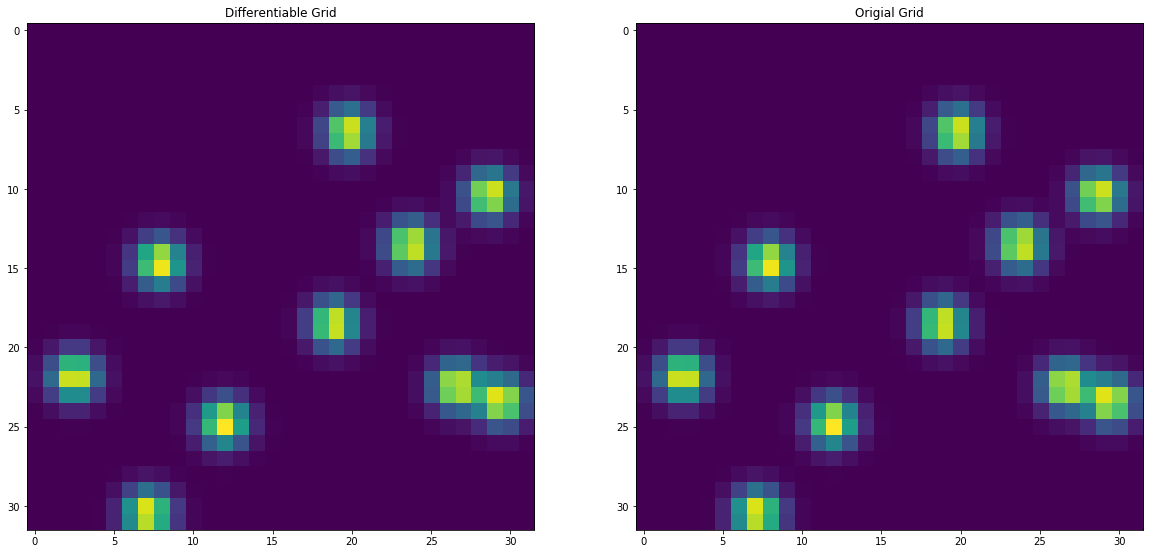

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(torch_grid.clone().detach().numpy())
ax2.imshow(out)

ax1.set_title('Differentiable Grid')
ax2.set_title('Origial Grid')

In [60]:
values = torch.from_numpy(out)
torch_coords =  torch.tensor(total_coords,dtype=torch.float32,requires_grad=True)

## Compare Starting Grid and Original Grid

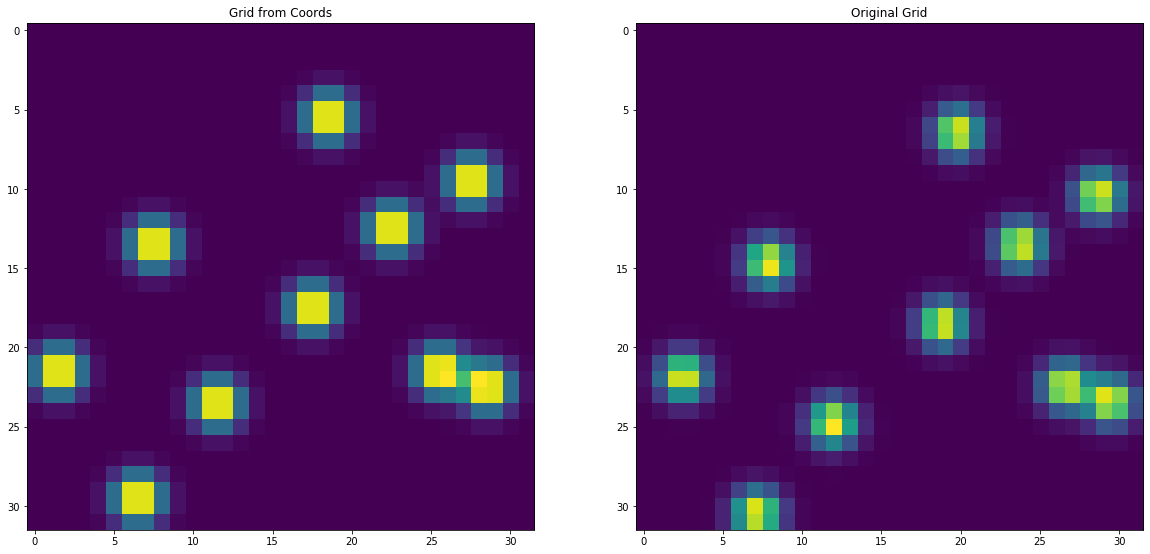

In [62]:
with torch.no_grad():
    agrid = diff_grid_generator(torch_coords, g_a, g_b)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(agrid.numpy()/ out.max())
    ax2.imshow(out / out.max())
    ax1.set_title('Grid from Coords')
    ax2.set_title('Original Grid')

In [51]:
optimizer = torch.optim.SGD([torch_coords], lr=0.01)

In [52]:
updated_coords = [] 
updated_grids = []
for i in range(10):
    optimizer.zero_grad()
    agrid = diff_grid_generator(torch_coords,g_a,g_b)       
    loss = torch.square(agrid-values).sum().float()
    loss.backward()

    optimizer.step()

    updated_grids.append(agrid.detach().numpy())

    print(loss.item())
    
    updated_coords.append(torch_coords.clone().detach().numpy())

0.5450337529182434
0.18316884338855743
0.03009514883160591
0.0049351891502738
0.001132264849729836
0.00027772350586019456
6.858836422907189e-05
1.6957477782852948e-05
4.19647494709352e-06
1.038629079630482e-06


In [53]:
updated_coords[0] - updated_coords[-1]

array([[-0.02508771, -0.01071936],
       [-0.02158314, -0.01627524],
       [-0.01895809, -0.01417136],
       [-0.02119356, -0.01872265],
       [-0.0049181 , -0.01584247],
       [-0.02428609, -0.01871616],
       [-0.01221257, -0.00433052],
       [-0.0216471 , -0.01647484],
       [-0.00591379, -0.0175786 ],
       [-0.00817981, -0.01297098]], dtype=float32)

Text(0.5, 1.0, 'After Optimization')

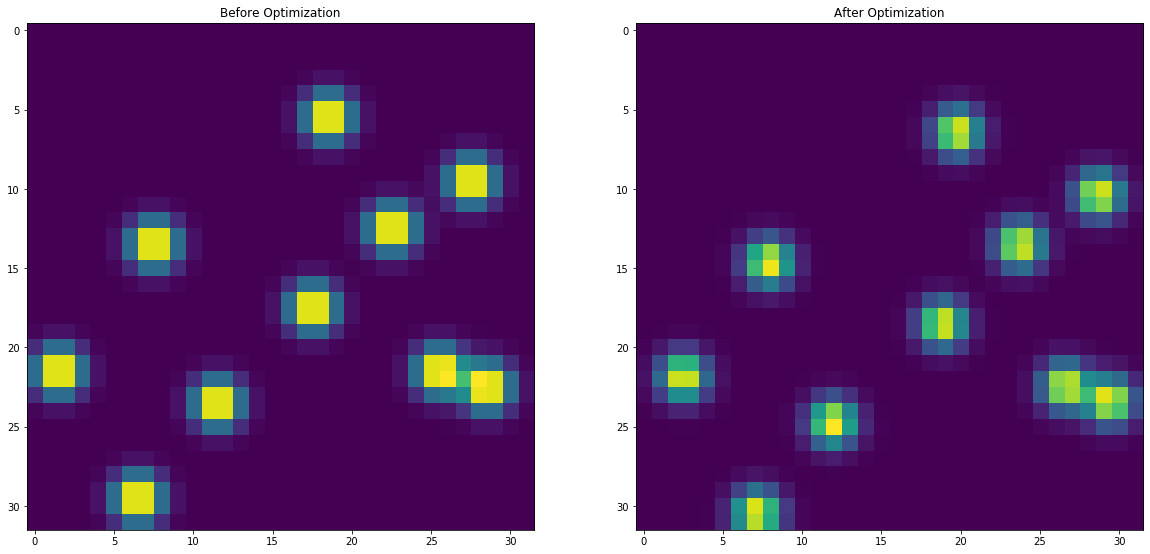

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(updated_grids[0])
ax2.imshow(updated_grids[-1])
ax1.set_title('Before Optimization')
ax2.set_title('After Optimization')

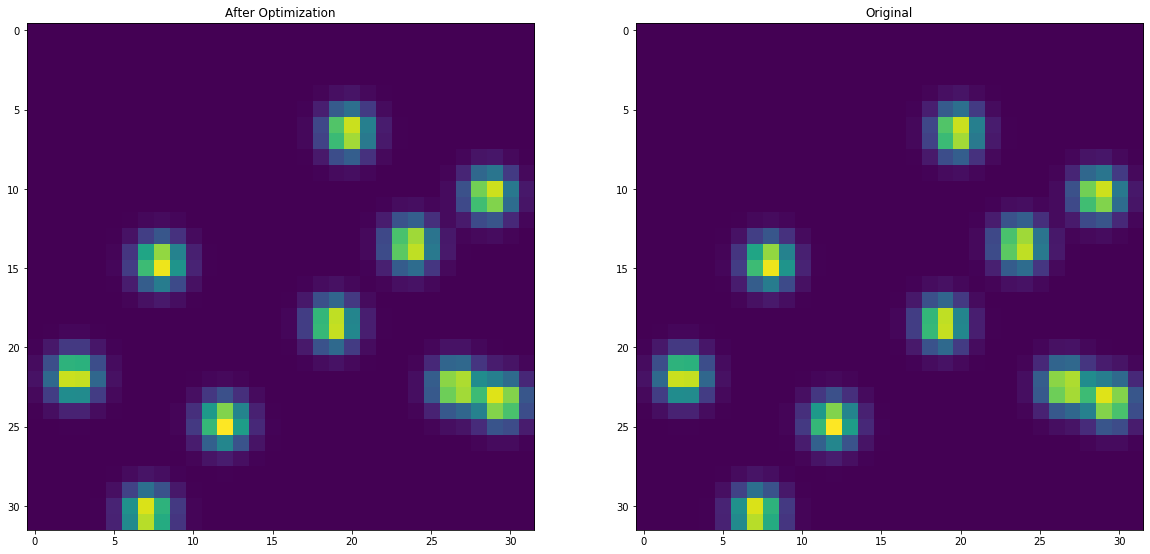

In [55]:
with torch.no_grad():
    agrid = diff_grid_generator(torch_coords,g_a,g_b)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(agrid)
    ax2.imshow(out)
    ax1.set_title('After Optimization')
    ax2.set_title('Original')

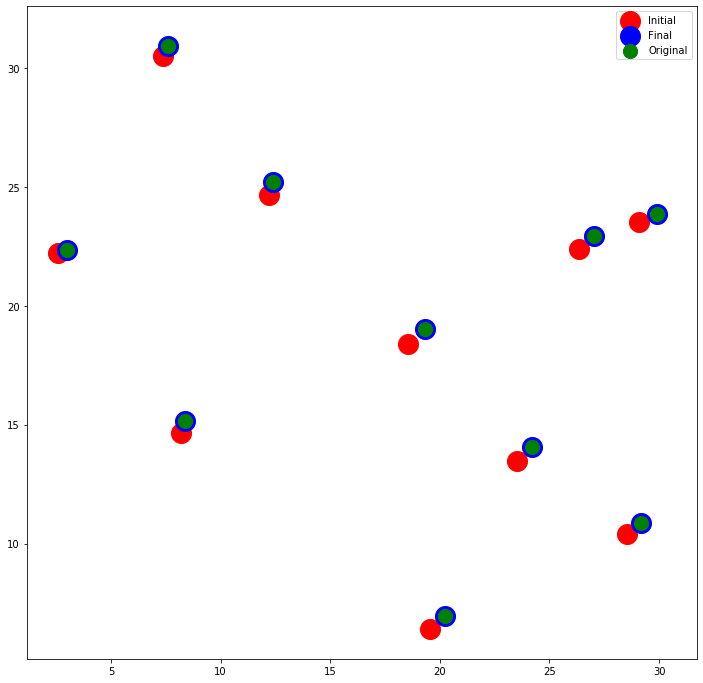

In [56]:
plt.figure(figsize=(12,12))
plt.scatter(updated_coords[0][:,0]*32, updated_coords[0][:,1]*32,c='r', s=400, label='Initial')
plt.scatter(updated_coords[-1][:,0]*32, updated_coords[-1][:,1]*32,c='b', s=400, label='Final')
plt.scatter(coords[:,0]*32, coords[:,1]*32, c='g', s=200, label='Original')
plt.legend()